### Здравствуйте, меня зовут *Николай Королев*, вот моё Задание №3!

---
# Сравнение моделей регрессии

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

np.random.seed(228)

In [2]:
rmodels = pd.read_table("rmodels.txt")
rmodels.sample(5)

,err1,err2
567,-1.079576,-1.064624
165,0.515506,0.505304
610,0.437605,0.461757
476,-0.868936,-0.867319
582,-0.172864,-0.158862


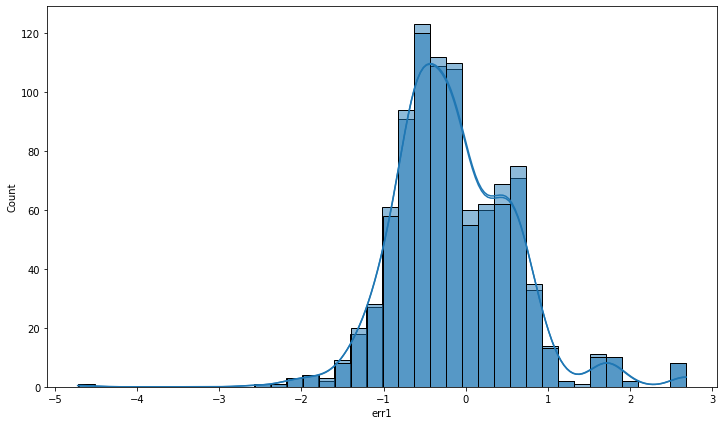

In [3]:
plt.figure(figsize=(12, 7))
sns.histplot(data=rmodels, x="err1", kde=True)
sns.histplot(data=rmodels, x="err2", kde=True)
plt.show()

Проверьте данные на нормальность с помощью тестов Колмогорова-Смирнова `kstest(x, 'norm')` и Шапиро-Уилка `shapiro(x)` библиотеки `scipy`. Можно ли использовать qq-график для обоснования использования методов, подразумевающих нормальность? То есть, можем ли мы на основе qq-графика удостовериться в том, что, например, двухвыборочный t-критерий Стьюдента использовать правомернo?

In [4]:
print(scipy.stats.kstest(rmodels["err1"], 'norm'))
print(scipy.stats.kstest(rmodels["err2"], 'norm'))

KstestResult(statistic=0.14963996161911286, pvalue=5.106513019549098e-18)
KstestResult(statistic=0.1508576745490468, pvalue=2.6272748192454066e-18)


In [5]:
print(scipy.stats.shapiro(rmodels["err1"]))
print(scipy.stats.shapiro(rmodels["err2"]))

ShapiroResult(statistic=0.955877959728241, pvalue=8.689481777590516e-16)
ShapiroResult(statistic=0.956586480140686, pvalue=1.198743473327388e-15)


Попробуем воспользоваться методом из `scipy.stats` и из `statsmodels` для построения QQ-графика:

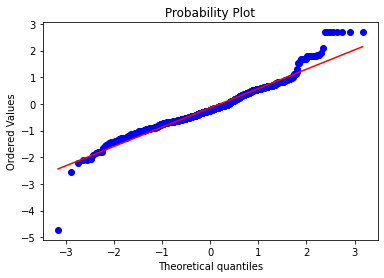

In [6]:
scipy.stats.probplot(rmodels["err1"], plot=plt)
plt.show()

/opt/hostedtoolcache/Python/3.9.6/x64/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


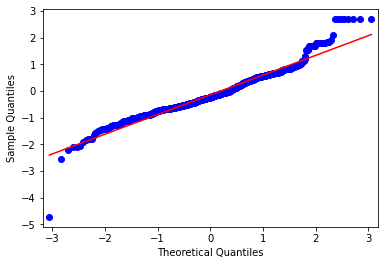

In [7]:
qqplot(rmodels["err1"], line='s')
plt.show()

Видим, что результат один и тот же. Теперь будет пользоваться только методом из `scipy.stats`.

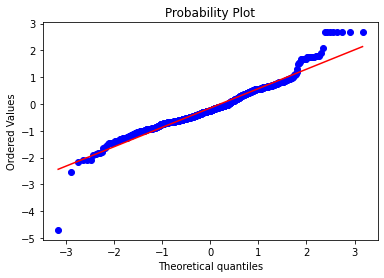

In [8]:
scipy.stats.probplot(rmodels["err2"], plot=plt)
plt.show()

Судя по QQ-графику распределение практически нормальное в наиболее вероятной части распределения (то есть посередине). На краях распределение не повторяет нормального распределения. Критерии Колмогорова-Смирнова и Шапиро-Уилка говорят о том, что мы должны отвергнуть гипотезу о нормальности распределения. Использование QQ-графика крайне нежелательно при обосновании методов, подразумевающих нормальность данных, т.к. в домашних работах и на семинарских занятиях уже разбирался случай, когда по QQ-графику кажется, что нормальности нет, но на самом деле, мы не можем отвергнуть её существование, а в данном случае ситуация обратная - кажется, что нормальность есть, но на самом деле распределение далеко не нормальное и пользоваться $t$-критерием Стьюдента нельзя. Использовать QQ-график имеет смысл только в очень маленьких выборках (меньше 50 примеров, например).

# Критерий Уилкоксона-Манна-Уитни для независимых выборок.

Первая идея, когда мы слышим слова “гипотеза о равенстве средних”, это, конечно, $t$-критерий Стьюдента. Это и понятно – действительно, если данные приходят из нормального распределения, то этот критерий достаточно мощный и использовать следует именно его. Кроме того, этот критерий достаточно устойчив к незначительным отклонениям от нормальности.

При этом на практике и в индустрии подавляющее большинство реальных данных никогда не распределено по нормальному закону. Есть ли хорошие альтернативы этому критерию?

Такой альтернативой, которую часто используют на практике, является критерий ранговых сумм Уилкоксона-Манна-Уитни. Рассмотрим модель смеси двух нормальных распределений

$$F(x) = (1-\varepsilon)\Phi(x) +\Phi(x/3) $$ 

Интересно, что уже при $\varepsilon \ge 0.01$ критерий ранговых сумм становится более точным критерием (имеет меньшую асимптотическую дисперсию), чем t-критерий. Кроме того есть теорема, что этот критерий не может потерять в асимптотической точности больше, чем $14$% и может быть сколь угодно более точным, чем $t$-критерий. Именно поэтому критерий ранговых сумм так важен для практического применения.

Проверьте гипотезу об однородности двух распределений, из которых получены выборки с помощью критерия Уилкоксона-Манна-Уитни.

In [9]:
def wilcoxon_man_witni(x, y):
    n1 = len(x)
    n2 = len(y)
    X = np.concatenate([x, y])
    ranks = scipy.stats.rankdata(X, method='average')
    statistic = ranks[:len(x)].sum()
    mean = n1 * (n1 + n2 + 1) / 2
    scale = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    pvalue = 2 * scipy.stats.norm(mean, scale).sf(abs(statistic))
    return statistic, pvalue

wilcoxon_man_witni(rmodels['err1'], rmodels['err2'])

(808112.0, 0.9087869916154557)

Как видно из критерия Уилкоксона-Манна-Уитни мы не можем отвергать гипотезу о том, что выборки имеют одинаковое среднее, если мы рассматриваем данные выборки, как независимые.

In [10]:
# Просто ради интереса, что получиться
scipy.stats.ttest_ind(rmodels['err1'], rmodels['err2'])

Ttest_indResult(statistic=0.09402186430285281, pvalue=0.9251022877301065)

Заметим, что аналогичный результат даёт и $t$-тест Стьюдента, хотя мы не можем им пользоваться в данном случае.

# Двухвыборочный перестановочный критерий для независимых выборок.

Другим мощным классом статистических критериев является класс перестановочных критериев.

Чтобы лучше понять сферу применений перестановочного критерия, дадим некоторое его сравнение с $t$-критерием:

- $t$-критерий формирует нулевую гипотезу относительно равенства средних, перестановочные критерии, как правило, задают нулевую гипотезу более широко – в терминах равенства распределений

Двухвыборочный $t$-критерий подразумевает, что нормальным должно быть распределение разностей $\bar{X}_1−\bar{X}_2$, и основывается на том, что правильным образом отнормированная эта разность распределена по закону Стьюдента. Перестановочные критерии считают статистику по данным, не прибегая к гипотезам о конкретном виде распределения, и оценивают распределение с помощью повторных выборок из данных.

- $t$-критерий дает точные значения достигаемого уровня значимости только если разность между средними в двух группах имеет распределение не сильно отклоняющееся от нормального. Перестановочный тест дает точное значение $p_{value}$ даже если распределение очень сильно отклоняется от нормального.

Перестановочный тест часто используется, когда нужна большая точность и предположение о нормальности данных нереалистично, а также для того, чтобы проверить эти предположения.

В частности, для проверки этого предположения часто прибегают к следующей процедуре. Из объединенной выборки выбирают случайно по схеме без возвращения столько объектов, сколько было изначально в одной из них (скажем, в первой). Остальные объекты полагают попавшими во вторую группу. Дальше считают некоторую статистику (в данном случае разницу средних значениях в этих двух группах) и ее запоминают.

Повторяя такую процедуру много раз, достигаемый уровень значимости получают как долю значений статистики (разности средних в нашем примере) таких же или более экстремальных, чем значение статистики, которое получилось по исходным выборкам (из которых мы делаем псевдовыборки). Если это значение находится далеко от $p_{value}$ $t$-критерия, то считается, что $t$-критерий для этих данных ненадежен.

Тонкий вопрос о том, сколько нужно сделать таких псевдовыборок, решают следующим образом. Если истинное значение достигаемого уровня значимости равно $p$, то стандартное отклонение оценки $p_{value}$ равно $\sqrt{\dfrac{p(1−p)}{B}}$, где $B$ - это количество сделанных псевдовыборок. Часто также переходят к верхней оценке этого значения $(\sqrt{\dfrac{1}{4B}})$.

- Реализуйте подобную процедуру самостоятельно для точности порядка $10^{-2}$.
- Cравните получившееся p-value с таковым для $t$-критерия.
- Cравните получившееся p-value с таковым для критерия Манна-Уитни `mannwhitneyu`.

Перестановочный критерий

In [11]:
from tqdm.notebook import tqdm

def permutation_test_ind(x, y, eps=1e-4, verbose=True, batch_size=64):
    n1 = len(x)
    n2 = len(y)
    X = np.concatenate([x, y])
    n_samples = int(np.ceil(1 / (4 * eps * eps)))
    statistics = []
    for t in tqdm(range(0, n_samples, batch_size), disable=not verbose, leave=False):
        current_batch_size = min(batch_size, n_samples - t)
        ids = np.random.uniform(size=(current_batch_size, n1 + n2))
        indices = ids.argpartition(n1 - 1, axis=-1)[:, :n1]
        sum1 = X[indices].sum(axis=-1)
        statistics.append(sum1)
    statistics = np.concatenate(statistics)
    statistics = -X.sum() / n2 + statistics * (n2 + n1) / n1 / n2
    real_stat = x.mean() - y.mean()
    pvalue = (abs(statistics) >= abs(real_stat)).mean()
    return pvalue
    
permutation_test_ind(rmodels['err1'], rmodels['err2'], eps=1e-2)

  0%|          | 0/40 [00:00<?, ?it/s]

0.932

$t$-критерий Стьюдента

In [12]:
scipy.stats.ttest_ind(rmodels['err1'], rmodels['err2'])

Ttest_indResult(statistic=0.09402186430285281, pvalue=0.9251022877301065)

Манн-Уитни

In [13]:
scipy.stats.mannwhitneyu(rmodels['err1'], rmodels['err2'], alternative='two-sided')

MannwhitneyuResult(statistic=404461.0, pvalue=0.9088230165122059)

Перестановочный тест показывает такое же значение `pvalue`, как и $t$-критерий, причём оно очень похоже на значение, полученное из критерия Манна-Уитни.

# Двухвыборочный перестановочный критерий для зависимых выборок.

В случае, если выборки связаны, то предыдущая схема неприменима: нет смысла переставлять значения между разными объектам. В таком случае прибегают к тому, что переставляют значения внутри каждого объекта, получая таким образом новые псевдовыборки, по которым также считают статистику и запоминают ее. Повторяя такую процедуру много раз, $p_{value}$ находят также, как и в предыдущем случае – считая долю таких же или еще более экстремальных значений статистики по псевдовыборкам в сравнении со статистикой, посчитанной по исходной выборке.

- Реализуйте описанную процедуру самостоятельно для точности порядка $10^{-2}$.
- Cравните получившееся $p_{value}$ с таковым для t-критерия.
- Cравните получившееся $p_{value}$ с таковым для критерия Уилкоксона `wilcoxon`.

Не забудьте, что вам в данном случае каждый из критериев нужно вызвать с параметрами, соответствующими связанным выборкам.

Перестановочный тест

In [14]:
rmodels

,err1,err2
0,-0.136588,-0.131182
1,-0.289688,-0.272290
2,0.613948,0.626212
3,-0.678777,-0.679792
4,0.647958,0.636701
...,...,...
893,-0.350998,-0.348859
894,-0.748893,-0.737836
895,0.582521,0.594445
896,0.345074,0.348436


In [15]:
def permutation_test_rel(x, y, eps=1e-4, verbose=True, batch_size=64):
    n = len(x)
    X = np.vstack([x, y]).T
    n_samples = int(np.ceil(1 / (4 * eps * eps)))
    statistics = []
    for t in tqdm(range(0, n_samples, batch_size), disable=not verbose, leave=False):
        current_batch_size = min(batch_size, n_samples - t)
        indices = np.random.choice(2, size=(current_batch_size, n), replace=True)
        sum1 = X[range(len(X)), indices].sum(axis=-1)
        statistics.append(sum1)
    statistics = np.concatenate(statistics)
    statistics = (2 * statistics - X.sum()) / n
    real_stat = x.mean() - y.mean()
    pvalue = (abs(statistics) >= abs(real_stat)).mean()
    return pvalue
    
permutation_test_rel(rmodels['err1'], rmodels['err2'], eps=1e-2)

  0%|          | 0/40 [00:00<?, ?it/s]

0.0

$t$-критерий Стьюдента

In [16]:
scipy.stats.ttest_rel(rmodels['err1'], rmodels['err2'])

Ttest_relResult(statistic=5.849013047863353, pvalue=6.924007691101239e-09)

Уилкоксон

In [17]:
scipy.stats.wilcoxon(rmodels['err1'], rmodels['err2'], alternative='two-sided')

WilcoxonResult(statistic=162287.0, pvalue=3.6665224292023824e-07)

Все результаты совпадают. Везде pvalue близки к нулю.

# Выводы

В случае отсутствия нормальности необходимо пользоваться непараметрическими критериями, которые в свою очередь могут давать оценки аналогичные параметрическим критериям. Перестановочный критерий является одним из самых точных критериев (т.к. $\epsilon$ можем выбирать любым), тем не менее он вычислительно дорогой.